# Bayesian Statistical Inference and Markov Chain Monte Carlo

We will start with an example from the previous week and build upon it. Say you have a distribution of sources with a strong prior and you observe them with some uncertainty. One example of this is the distribution of distances to stars. Assuming a constant density of stars, the underlying distribution should scale with $r^2$. This is our prior:

$$ P(r) \sim r^2 $$

This must be normalized. Obviously we cannot observe stars at an infinite distance, and doing so would cause the prior to diverge. We must impose, somewhat artificially, a maximum distance, $r_max$, to calculate the normalization constant. Our prior becomes:

$$ P(r) = 3 \frac{r^2}{r_{\rm max}^3} $$

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize as so
from scipy.integrate import quad
import time

%matplotlib inline

### First, let's generate a sample from an exponential and add Gaussian noise

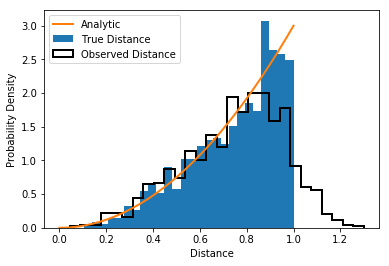

In [91]:
# Draw random distances using inverse sampling
N_stars=1000
dist_max = 1.0 # in kpc
dist = (np.random.uniform(size=N_stars))**(1.0/3.0) * dist_max

# Plot sample
bins = np.linspace(0.0, 1.0, 30)
plt.hist(dist, bins=bins, normed=True, label='True Distance')

# Plot analytic
plt.plot(bins, 3.0 * bins**2 * dist_max**-3, linewidth=2.0, label='Analytic')

# Now add uncertainties of 100 pc
dist_obs = dist + np.random.normal(size=size, scale=0.1)
# Array of errors
dist_err = 0.1 * np.ones(len(dist_obs))


bins = np.linspace(0.0, 1.3, 30)
plt.hist(dist_obs, bins=bins, normed=True, histtype='step', 
         linewidth=2.0, color='k', label='Observed Distance')


plt.xlabel("Distance")
plt.ylabel("Probability Density")

plt.legend(loc=2)

plt.show()

### First model: recover the exponential in the power law ignoring uncertainties

Let's imagine that we do not know the exponential in the power law, $\alpha$, and we want to solve for it. The correct answer is be 2. Let's see if we can recover that.

We start with our probability notation. We want to determine $P(\alpha | \{ r \})$. We use our Bayesian formalism to split this into a prior and a likelihood:

$$ P(\alpha | \{ r \}) = \frac{1}{\mathcal{Z}} P(\{ r \} | \alpha) P(\alpha), $$

where $\mathcal{Z}$ is a normalization constant, which we have previously called the "evidence." 

Prior: $P(\alpha)$  
Likelihood: $P(\{ r \} | \alpha)$

#### What should the prior look like?

In this case the prior will have a minimal effect, but we would like to constrain it to positive values though. Our prior will be:
$$ P(\alpha) = \cases{0 : \alpha <= 0 \\ 1 : \alpha > 0} $$

NOTE: This prior is technically unnormalized and is therefore called an "improper prior." We could fix this by additionally setting a maximum value for $\alpha$ and setting the prior to $1/\alpha_{\rm max}$ for $0 < \alpha < \alpha_{\rm max}$. For simplicity, we will keep this prior unnormalized though.

#### What about the likelihood?

This is seemingly quite simple but can lead to much hand-wringing if you think about it too much. I will state it unproven here: the overal likelihood is the product of the likelihood of each data point, and the likelihood of each data point is the *normalized* probability density function evaluated at each data point:

$$ P(\{ r \} | \alpha) = \prod P(r | \alpha) $$
where
$$ P(r | \alpha) = (\alpha+1) \frac{r^{\alpha}}{r_{\rm max}^{\alpha + 1}} $$

#### Converting to the log of the posterior

For numerical simplicity, we use the (natural) log of the posterior, and therefore the log of the prior and the posterior. These become:

$$ \log P(\alpha) = \cases{-\infty : \alpha <= 0 \\ 0 : \alpha > 0} $$
$$ \log P(\{ r \} | \alpha) = \sum \log \left[ (\alpha+1) \frac{r^{\alpha}}{r_{\rm max}^{\alpha + 1}} \right] $$

and the posterior is the sum of these two factors (we ignore $\mathcal{Z}$ here):

$$ \log P(\alpha | \{ r \}) = \log P(\alpha) + \log P(\{ r \} | \alpha) $$

### Now, some code

In [92]:
# This is the normalized pdf for arbitrary alpha
def func_pdf(alpha, x_max, x):
    P_x = (alpha+1.0) * x**(alpha) / dist_max**(alpha+1.0)
    P_x[x>x_max] = 0.0 
    P_x[x<0.0] = 0.0
    
    return P_x

def ln_prior(alpha):
    if alpha < 0.0:
        return -np.inf
    
    return 0.0


def ln_likelihood(alpha, x_max, x_obs):
    return np.sum(np.log(func_pdf(alpha, x_max, x_obs)))


def ln_posterior(alpha, x_max, x_obs):
    
    lp = ln_prior(alpha)
    ll = ln_likelihood(alpha, x_max, x_obs)
        
    return lp+ll


def neg_ln_posterior(alpha, x_max, x_obs):
    return -ln_posterior(alpha, x_max, x_obs)

In [93]:
# We will give it the wrong starting value
p0 = 1.0

res = so.minimize(neg_ln_posterior, p0, args=(1.0, dist))
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")

Expected result: 2.0
Result: [ 1.9399843]


### Next, let's see if we can account for the observational uncertainties

Let's first try to run our simple model on the observed distances.

In [94]:
res = so.minimize(neg_ln_posterior, p0, args=(1.0, dist_obs))
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")

Expected result: 2.0
Result: [ 1.]


/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


The code broke. Why did this happen? The short answer is that, since we have added some observational uncertainties, the observed distribution has negative distances and distances above the maximum allowed by our likelihood function. We can try a few small hacks to get around this. First, we can set every negative distance to something very small and positive and every distance above dist_max to 99% of dist_max. As an alternative hack, we can remove these data from our sample. See the code below.

NOTE: This is entirely unjustified statistically. We would like to perform the proper treatment which is further below.

In [96]:
dist_obs_hack = np.copy(dist_obs)
dist_obs_hack[dist_obs_hack < 0.0] = 0.01
dist_obs_hack[dist_obs_hack > 1.0] = 0.99

res = so.minimize(neg_ln_posterior, p0, args=(1.0, dist_obs_hack))
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")
    
    
dist_obs_hack = np.copy(dist_obs)
dist_obs_hack = dist_obs_hack[dist_obs_hack < 0.0]
dist_obs_hack = dist_obs_hack[dist_obs_hack > 1.0]

res = so.minimize(neg_ln_posterior, p0, args=(1.0, dist_obs_hack))
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")

Expected result: 2.0
Result: [ 1.79841101]
Expected result: 2.0
Result: [ 1.]


It should be no surprise that this failed - we are doing the *wrong* thing.

#### Let's do the right thing

We want to convolve the power law distribution with Gaussian uncertainties corresponding the the observational errors. Why is this justified? Consider a star observed at a distance of 0.5 kpc. Obviously, its real distance is not actually 0.5 kpc. Instead, we can only say its distance is characterized by a Gaussian around the observed, multiplied by the underlying distance distribution, our power law. In fact, this defines our new likelihood function for individual data points:

$$ P( r | \alpha) = \int dr' \mathcal{N}(r' | r, \sigma_r) (\alpha+1) \frac{r'^{\alpha}}{r_{\rm max}^{\alpha + 1}} $$

Hopefully this makes some intuitive sense.

#### The Bayesian derivation

Let's define the difference between the observed distance ($r_{\rm obs}$) and the true, underlying distance ($r_{\rm true}$). First, we take our likelihood for an individual observation and marginalize over the underlying distance, $r_{\rm true}$:

$$ P( r_{\rm obs} | \alpha) = \int_{-\infty}^{\infty} dr_{\rm true} P(r_{\rm true}, r_{\rm obs} | \alpha) $$
$$ P( r_{\rm obs} | \alpha) = \int_{0}^{r_{\rm max}} dr_{\rm true} P(r_{\rm obs} | r_{\rm true}) P(r_{\rm true} | \alpha) $$

$P(r_{\rm obs} | r_{\rm true})$ is the Gaussian uncertainty on the observation, and $P(r_{\rm true} | \alpha)$ is the power law distribution previously defined. Remember that the power law is the distribution in $r_{\rm true}$ not $r_{\rm obs}$.

By inserting these terms into the above equation, we realize that it is identical to the intuitive equation we derived above ($r_{\rm obs} = r; r_{\rm true} = r'$).

Notice that the code will take a substantially longer time to run - this is due to the addition of only one integral within the minimzation routine. If you are marginalizing over two or three parameters (simultaneously dealing with two or three observational uncertainties) the problem can quickly become intractable.

#### Code, with our updated likelihood function

In [97]:
# This is the normalized pdf for arbitrary alpha
def func_pdf(alpha, x_max, x):
    P_x = (alpha+1.0) * x**(alpha) / dist_max**(alpha+1.0)
    
    if type(x) is np.ndarray:
        P_x[x>x_max] = 0.0 
        P_x[x<0.0] = 0.0
    elif x>x_max:
        return 0.0
    elif x<0.0:
        return 0.0
    else:
        pass
        
    return P_x

def func_integrand(x, alpha, x_max, x_obs, x_err):
    return stats.norm.pdf(x, loc=x_obs, scale=x_err) * func_pdf(alpha, x_max, x)

def ln_prior(alpha):
    if alpha < 0.0:
        return -np.inf
    
    return 0.0


def ln_likelihood(alpha, x_max, x_obs, x_err):
    
    ln_likelihood = 0.0
    for i in range(len(x_obs)):
        
        # Limits are either the limits of the pdf or 5 sigma from the observed value
        a = max(0.0, x_obs[i]-3.0*x_err[i])
        b = min(x_max, x_obs[i]+3.0*x_err[i])
        
        val = quad(func_integrand, a, b, args=(alpha, x_max, x_obs[i], x_err[i]), 
                   epsrel=1.0e-4, epsabs=1.0e-4)
        ln_likelihood += np.log(val[0])
    
    return ln_likelihood


def ln_posterior(alpha, x_max, x_obs, x_err):
    
    lp = ln_prior(alpha)
    ll = ln_likelihood(alpha, x_max, x_obs, x_err)
                        
    return lp+ll


def neg_ln_posterior(alpha, x_max, x_obs, x_err):
    return -ln_posterior(alpha, x_max, x_obs, x_err)

Expected result: 2.0
Result: [ 1.94863517]
Elapsed time: 103.32101392745972 seconds


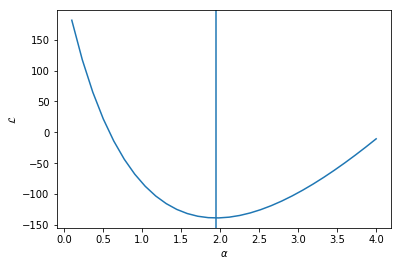

In [105]:
# We will give it the wrong starting value
p0 = 4.0
dist_max = 1.0

tmp_x = np.linspace(0.1, 4.0, 30)
tmp_y = np.zeros(len(tmp_x))
for i in range(len(tmp_x)):
    tmp_y[i] = neg_ln_posterior(tmp_x[i], dist_max, dist_obs, dist_err)
plt.plot(tmp_x, tmp_y)


start = time.time()
res = so.minimize(neg_ln_posterior, p0, args=(dist_max, dist_obs, dist_err))
end = time.time()

if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")
    
print("Elapsed time:", end-start, "seconds")

plt.axvline(res.x)

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathcal{L}$")
plt.show()

### How do we determine uncertainties?

Determining uncertainties on your model is a tricky thing. If the sample were just Gaussian error bars, with known uncertainties, our understanding of $\chi^2$ distributions can help us out here. Unfortunately, only a small set of problems are conducive to $\chi^2$ distributions.

### Markov Chain Monte Carlo!

This is one of a few ways of calculating uncertainties, but this one is a flexible, robust, and relatively simple method. 

We will discuss the Metropolis-Hastings algorithm, but note that there are *many* others out there. Here are the steps in the sequence:

1. We start with one set of parameters $\theta_1$. In our case, $\theta_1$ is simply $\alpha$ since we have only one parameter in our model, but to keep the discussion generalized, we will imagine that $\theta$ can contain 1, 5, or even a million separate parameters. This first value starts our Markov chain. 

2. Using some method we obtain a new trial set of parameters $\theta_2$. It is important that this set is chosen randomly, but based on the first set. This is one place where the "Monte Carlo" in MCMC comes from. The simplest method to obtain our new parameter values will be to add some random (Gaussian?) noise to our current value: $\theta_2 = \theta_1 + \epsilon$. You typically want to tune the value for $\epsilon$ to optimize the process.

3. Now, we want to calculate and compare the posterior probabilities for both $\theta_1$ and $\theta_2$. If $\frac{\theta_2}{\theta_1} > 1$ (i.e., the new parameter is better than the current one) we always move the chain to $\theta_2$. If $\frac{\theta_2}{\theta_1} < 1$ we *might* move the chain to $\theta_2$; we move to $\theta_2$ with probability $\frac{\theta_2}{\theta_1}$. In practice, we draw a random number from a uniform distribution between 0 and 1. If that random number is less than $\frac{\theta_2}{\theta_1}$, we move the chain to $\theta_2$. If, instead that random number is greater than $\frac{\theta_2}{\theta_1}$, we keep $\theta_1$ for another iteration.

4. Now that we have our new value for $\theta$, we return to step 2 and repeat for as many iterations as we want. Often this is in the thousands or more.

#### Let's code it up

In [119]:
def metro_hastings(ln_posterior, theta_0, N_steps, args=[]):
    
    chain = np.zeros(N_steps)
    chain[0] = theta_0
    
    for i in range(N_steps-1):
        theta_trial = chain[i] + np.random.normal(scale=0.1)
        
#         print(chain[i], theta_trial)
        
        chain[i+1] = one_step(theta_trial, chain[i], ln_posterior, args)
            
    return chain


def one_step(theta_1, theta_2, ln_posterior, args=[]):
    
    if args is None:
        ln_posterior_1 = ln_posterior(theta_1)
        ln_posterior_2 = ln_posterior(theta_2)
    else:
        ln_posterior_1 = ln_posterior(theta_1, *args)
        ln_posterior_2 = ln_posterior(theta_2, *args)

    if ln_posterior_2 > ln_posterior_1: 
        return theta_2
        
        
    ran_y = np.random.uniform()
    
    if ran_y > np.exp(ln_posterior_2 - ln_posterior_1): 
        return theta_1
    else:
        return theta_2

In [122]:
start = time.time()

alpha_0 = 3.0
chain = metro_hastings(ln_posterior, alpha_0, args=(dist_max, dist_obs, dist_err), N_steps=500)

end = time.time()
print("Elapsed time:", end-start, "seconds")

Elapsed time: 377.74355602264404 seconds


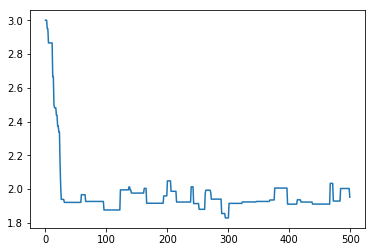

In [123]:
plt.plot(chain)
plt.show()

### One note about calculating integrals

Particularly when it comes to Gaussians, it is often easier to calculate integrals using Monte Carlo methods, rather than typical integration techniques. The basic idea: We draw $N$ random draws of $x$ from the distribution $F(x)$, then take the average of $G(x)$ evaluated at these randomly drawn $x_k$.

$$ \int_{\infty}^{\infty}\ F(x)\ G(x)\ dx \approx \frac{1}{N} \sum^N_k G(x_k) $$
$$ x_k \sim F(x) $$

This can help *drastically* speed up the integration, but it depends on your required accuracy. Broad testing is required to really understand both the required $N$ necessary for your target accuracy and if this is more efficient than scipy.optimize's quad function, or some other numerical integration method.

#### Some code to speed up the integration

We rewrite the likelihood function. Everything else remains the same

In [117]:
def ln_likelihood(alpha, x_max, x_obs, x_err):
    
    ln_likelihood = 0.0
    for i in range(len(x_obs)):
        
        a, b = (0.0 - x_obs[i]) / x_err[i], (x_max - x_obs[i]) / x_err[i]
#         ran_x = stats.norm.rvs(loc=x_obs[i], scale=x_err[i], size=10000)
        ran_x = stats.truncnorm.rvs(a, b, loc=x_obs[i], scale=x_err[i], size=1000)
        
        
        ran_y = func_pdf(alpha, x_max, ran_x)
        
        ln_likelihood += np.log(np.mean(ran_y))
    
    return ln_likelihood

### Burn in

The first steps in the chain are not in the optimal regime. This is called the "burn-in" and is thrown away. In principle, there is no absolute way to determine if your chains have converged to the optimal region of parameter space. In practice, unless your problem is pathological, it is usually pretty obvious. Do remember this can be an issue and take care!

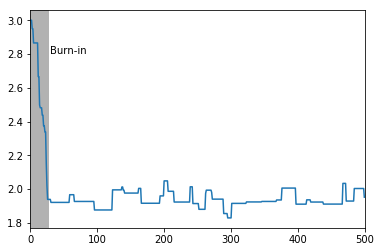

In [132]:
plt.axvline(13, color='k', linewidth=20, alpha=0.3)

plt.plot(chain)

plt.text(30, 2.8, "Burn-in")

chain_converged = chain[25:]

plt.xlim(0,500)
plt.show()

### Acceptance fraction

The optimal acceptance fraction is 23.4%. I've never seen the derivation of this number, but I'm sure it exists in various places online. By tuning $\epsilon$, we can try to get as close as possible to 23%.

In [133]:
N_accepted = 0

for i in range(len(chain_converged)-1):
    if chain_converged[i] != chain_converged[i+1]:
        N_accepted += 1
        
print("Acceptance fraction:", N_accepted/len(chain_converged))

Acceptance fraction: 0.07789473684210527


Our acceptance fraction is low. We can increase this by decreasing $\epsilon$, but note this should increase the burn-in time.

### Autocorrelation

Each link in the Markov Chain is not independent. Why? Because each data point is related to the previous one. Therefore not every link is an independent data point. Only every $N$ number of data points are independent. The easiest way to find $N$, is to take the offset at which the autocorrelation is approximatly zero. If we want to be rigorous about it, we should only report 1/$N$ samples in our final result.


### Our results

Now, we can plot the posterior distribution of $\alpha$ to obtain our final result.

Maximum a posteriori value: 1.9242045347
1-sigma confidence level: 1.91148200862 1.99385762073


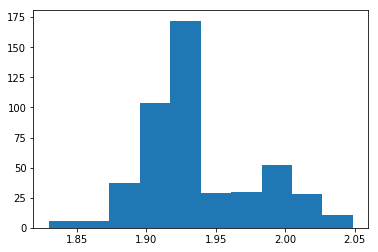

In [135]:
plt.hist(chain_converged)

chain_sorted = np.sort(chain_converged)
print("Maximum a posteriori value:", np.median(chain_sorted))
print("1-sigma confidence level:", 
      chain_sorted[int(0.16*len(chain_sorted))],
      chain_sorted[int(0.84*len(chain_sorted))])


plt.show()

### What about for a single system?

Now that we have identified the overall distribution, what if we want to know the distance to a single system? We can again use our Bayesian math here.

$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \int_{-\infty}^{\infty} d\alpha\ P(r_{\rm real}, \alpha | \{r_{\rm obs}\}) $$
$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \int_{-\infty}^{\infty} d\alpha\ P(r_{\rm real} | r_{\rm obs}, \alpha)\ P(\alpha | \{r_{\rm obs}\}) $$

#### Here's where Bayesian statistics really shines. 

If we wanted to use frequentist statistics, we would take the Gaussian approximation to $P(\alpha | \{r_{\rm obs}\})$ that we found above: 1.95$\pm$0.04. We would then calculate the integral above. 

Instead, we can directly use samples from the posterior distribution of $\alpha$ which we calculated from our MCMC model to calculate the integral:
$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \frac{1}{N} \sum_k P(r_{\rm real} | r_{\rm obs}, \alpha_k) $$

This term inside the sum is simply the integrand that we had originally calculated:
$$ P(r_{\rm real} | r_{\rm obs}, \alpha_k) = \mathcal{N}(r_{\rm real} | r_{\rm obs}, \sigma_r) (\alpha+1) \frac{r_{\rm real}^{\alpha}}{r_{\rm max}^{\alpha + 1}}$$

#### Some code

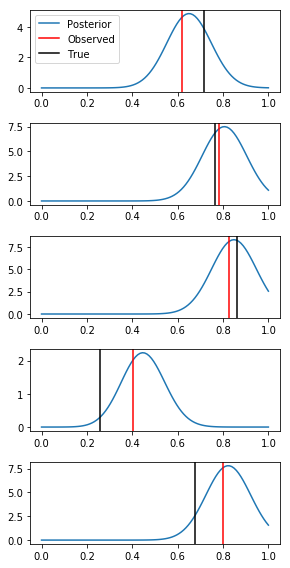

In [152]:
def prob_r(alpha_chain, r_real, r_obs, r_err):

    term_1 = stats.norm.pdf(r_real, loc=r_obs, scale=r_err)
    return term_1 * np.mean(func_pdf(alpha_chain, dist_max, r_real))


ran_i = np.random.randint(len(dist_obs), size=5)

fig, ax = plt.subplots(5, 1, figsize=(4,8))


tmp_x = np.linspace(0.0, 1.0, 100)
tmp_y = np.zeros(len(tmp_x))

for j in range(5):
    for i in range(len(tmp_y)):
        tmp_y[i] = prob_r(chain_converged, tmp_x[i], dist_obs[ran_i[j]], dist_err[ran_i[j]])


    ax[j].plot(tmp_x, tmp_y, label='Posterior')
    ax[j].axvline(dist_obs[ran_i[j]], color='r', label="Observed")
    ax[j].axvline(dist[ran_i[j]], color='k', label='True')

ax[0].legend(loc=2)
plt.tight_layout()
plt.show()